<a href="https://colab.research.google.com/github/muharyaanandas/CNN-Waste-Classification/blob/main/Standar_CNN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Read all image types

def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"), contains=contains)

def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"), contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath

In [ ]:
import os
import cv2
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Function to clean up path strings
# def clean_path(path):
#     return path.replace("\\ ", " ")

In [ ]:
# Define data path (adjust to your dataset's directory structure)
data_dir = '/content/drive/MyDrive/Klasifikasi_Sampah/Dataset'

# Check if the directory exists
if not os.path.exists(data_dir):
    print(f"Path {data_dir} tidak ditemukan. Pastikan path benar dan direktori ada.")
else:
    print(f"Path {data_dir} ditemukan.")
    dirs = os.listdir(data_dir)

    # Initialize a dictionary to keep count of images in each category
    image_counts = {}

    for dir_name in dirs:
        dir_path = os.path.join(data_dir, dir_name)
        # Use glob to list all image files in the directory, considering common image formats
        image_files = glob.glob(os.path.join(dir_path, '*.*'))
        # Filter out non-image files
        image_files = [file for file in image_files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
        # Count the number of images
        image_count = len(image_files)
        # Store the count in the dictionary
        image_counts[dir_name] = image_count

    # Print the total images for each category
    for category, count in image_counts.items():
        print(f"Total {category} images: {count}")

Path /content/drive/MyDrive/Klasifikasi_Sampah/Dataset ditemukan.
Total Organik images: 100
Total Anorganik images: 109
Total B3 images: 101


In [ ]:
# Inisialisasi ImageDataGenerator dengan pembagian data training dan validation lebih efektif
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.25  # Meningkatkan jumlah data validasi menjadi 25%
)

In [ ]:
# Lokasi dataset
data_dir = '/content/drive/MyDrive/Klasifikasi_Sampah/Dataset'

In [ ]:
# Split the dataset into training and testing
# X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
# Generator data training
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Generator data validation
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 233 images belonging to 3 classes.
Found 77 images belonging to 3 classes.


In [ ]:
# Membangun model dengan penambahan Batch Normalization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(3, activation='softmax')
])

In [ ]:
# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks untuk menyimpan model terbaik dan menghentikan jika stagnan
callbacks = [
    ModelCheckpoint('model.h5', save_best_only=True, verbose=1),
    EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
]

In [ ]:
# Data generator
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# train_datagen = ImageDataGenerator(rescale=1./255)
# validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Training model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=25,  # Meningkatkan jumlah epoch
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks
)

# Mencetak hasil training dan validation terbaik
print(f"Highest Training Accuracy: {max(history.history['accuracy'])}")
print(f"Highest Validation Accuracy: {max(history.history['val_accuracy'])}")

Epoch 1/25
7/7 [==============================] - ETA: 0s - loss: 1.6345 - accuracy: 0.4279
Epoch 1: val_loss improved from inf to 1.15258, saving model to model.h5
7/7 [==============================] - 61s 9s/step - loss: 1.6345 - accuracy: 0.4279 - val_loss: 1.1526 - val_accuracy: 0.3750
Epoch 2/25
7/7 [==============================] - ETA: 0s - loss: 1.0010 - accuracy: 0.6269
Epoch 2: val_loss did not improve from 1.15258
7/7 [==============================] - 58s 9s/step - loss: 1.0010 - accuracy: 0.6269 - val_loss: 1.2691 - val_accuracy: 0.3594
Epoch 3/25
7/7 [==============================] - ETA: 0s - loss: 0.9920 - accuracy: 0.5893
Epoch 3: val_loss improved from 1.15258 to 1.11353, saving model to model.h5
7/7 [==============================] - 50s 7s/step - loss: 0.9920 - accuracy: 0.5893 - val_loss: 1.1135 - val_accuracy: 0.3125
Epoch 4/25
7/7 [==============================] - ETA: 0s - loss: 0.8199 - accuracy: 0.6418
Epoch 4: val_loss did not improve from 1.11353
7/7 [==

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

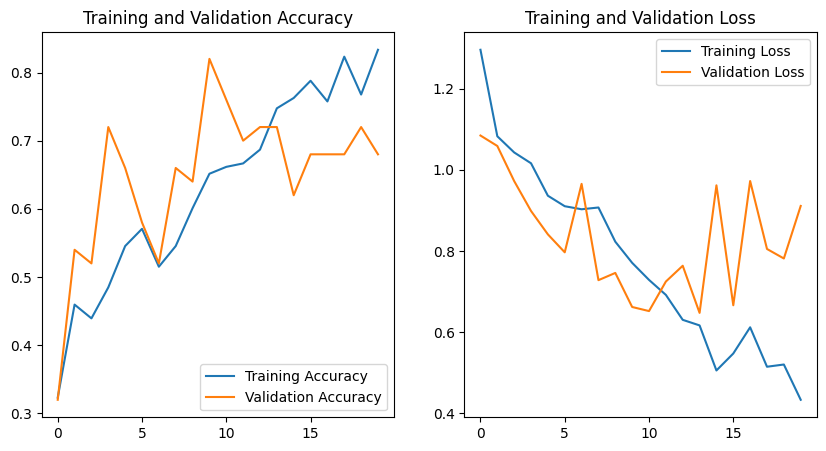

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()